In [1]:
import numpy as np
import pandas as pd
import os
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
# read file
dataset = os.path.expanduser("~/Downloads/IMDB_Dataset.csv")
data = pd.read_csv(dataset)
data = data[:20000]
print(data.shape)
data.head(10)

(20000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


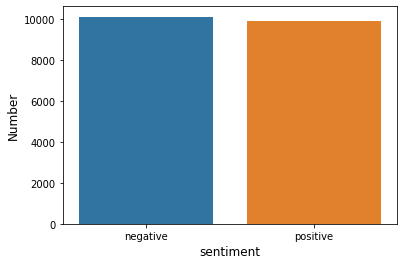

In [3]:
# balanced data
data['sentiment'].value_counts()

# visualization
label_number = data.sentiment.value_counts()
plt.figure(figsize = (6,4))
sns.barplot(label_number.index, label_number.values, alpha = 1)
plt.xlabel('sentiment', fontsize =12)
plt.ylabel('Number', fontsize = 12)
plt.show()

In [4]:
from bs4 import BeautifulSoup

# data preprocessing
def clean_text(text):
    # remove html 
    text = BeautifulSoup(text, "html.parser").get_text()
    # remove special characters and brackets
    text = re.sub(r'[^a-zA-z0-9\s]', '', text)
    text = re.sub('\[[^]]*\]', '', text)
    return text

data['review'] = data['review'].apply(clean_text)

In [5]:
# stemming
def stem_text(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

data['review'] = data['review'].apply(stem_text)

data['review']

0        one of the other review ha mention that after ...
1        A wonder littl product the film techniqu is ve...
2        I thought thi wa a wonder way to spend time on...
3        basic there a famili where a littl boy jake th...
4        petter mattei love in the time of money is a v...
                               ...                        
19995    ok for starter taxi driver is amaz thi thi is ...
19996    it sort of hard for me to say it becaus I so g...
19997    I still like it though warren beatti is onli f...
19998    We could still use black adder even today imag...
19999    thi socal documentari tri to tell that usa fak...
Name: review, Length: 20000, dtype: object

In [6]:
# tokenization
def tokenize(text):
    tokenizer=ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    eng_stopwords = nltk.corpus.stopwords.words('english')
    removed = [token for token in tokens if token.lower() not in eng_stopwords]
    text = ' '.join(removed) 
    return text

data['review'] = data['review'].apply(tokenize)

data['review']

0        one review ha mention watch 1 Oz episod youll ...
1        wonder littl product film techniqu veri unassu...
2        thought thi wa wonder way spend time hot summe...
3        basic famili littl boy jake think zombi hi clo...
4        petter mattei love time money visual stun film...
                               ...                        
19995    ok starter taxi driver amaz thi thi taxi drive...
19996    sort hard say becaus greatli enjoy target pape...
19997    still like though warren beatti onli fair comi...
19998    could still use black adder even today imagin ...
19999    thi socal documentari tri tell usa fake moonla...
Name: review, Length: 20000, dtype: object

In [7]:
# split the dataset into training and testing datasets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size =0.30, random_state=42)

train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']
train_y.value_counts()

negative    7038
positive    6962
Name: sentiment, dtype: int64

In [8]:
# bag of words
# tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
tv_train_x = tv.fit_transform(train_x)
tv_test_x = tv.transform(test_x)

In [9]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(tv_train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
# svc
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(tv_train_x, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
# accuracy
print(lr.score(tv_test_x, test_y))
print(svc.score(tv_test_x, test_y))

# precision, recall, and f1 scores
from sklearn.metrics import classification_report

print(classification_report(test_y, lr.predict(tv_test_x), labels = ['positive','negative']))
print(classification_report(test_y, svc.predict(tv_test_x), labels = ['positive','negative']))

0.7233333333333334
0.7275
              precision    recall  f1-score   support

    positive       0.77      0.62      0.69      2941
    negative       0.69      0.82      0.75      3059

    accuracy                           0.72      6000
   macro avg       0.73      0.72      0.72      6000
weighted avg       0.73      0.72      0.72      6000

              precision    recall  f1-score   support

    positive       0.74      0.68      0.71      2941
    negative       0.72      0.77      0.74      3059

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000



In [ ]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(tv_train_x.toarray(), train_y)

In [ ]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(tv_train_x, train_y)

In [ ]:
# accuracy 
print(dt.score(tv_test_x, test_y))
print(nb.score(tv_test_x.toarray(), test_y))

In [ ]:
# precision, recall, and f1 scores
from sklearn.metrics import classification_report

print(classification_report(test_y,
                            lr.predict(tv_test_x),
                            labels = ['positive','negative']))
print(classification_report(test_y,
                            svc.predict(tv_test_x),
                            labels = ['positive','negative']))
print(classification_report(test_y,
                            dt.predict(tv_test_x),
                            labels = ['positive','negative']))
print(classification_report(test_y,
                            nb.predict(tv_test_x.toarray()),
                            labels = ['positive','negative']))